In [16]:
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from scipy.sparse import csr_matrix

from keras.optimizers.legacy import Adam
from tensorflow import data, SparseTensor
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential, clone_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

raw_data = pd.read_csv('dataset.csv')
number_of_columns = len(raw_data.columns)
number_champions = (number_of_columns - 1) // 12
X = raw_data.drop('blueWin', axis=1)
y = raw_data['blueWin']

In [99]:
def prepare_sparse_dataset(X, y, batch_size=32):
    # Function to convert sparse matrix to SparseTensor, then to Dataset
    def _sparse_matrix_to_sparse_tensor(X):
        coo = X.tocoo()
        indices = np.mat([coo.row, coo.col]).transpose()
        return SparseTensor(indices, coo.data.astype(np.float32), coo.shape)
    
    X_sparse_tensor = _sparse_matrix_to_sparse_tensor(X)
    dataset = data.Dataset.from_tensor_slices((X_sparse_tensor, y))
    dataset = dataset.batch(batch_size).prefetch(data.experimental.AUTOTUNE)
    return dataset

In [113]:
def simple_validation(model, X_train, y_train, X_test, y_test, learning_rate=0.001, epochs=20, patience=5, is_sparse=False, save_model=None):
    # Clone and compile model
    current_model = clone_model(model)
    current_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy')


    # Early stopping
    stopper = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)
    
    # Train the model and make predictions
    if (is_sparse):
        train_dataset = prepare_sparse_dataset(X_train, y_train)
        val_dataset = prepare_sparse_dataset(X_test, y_test)
        current_model.fit(train_dataset, epochs=epochs, callbacks=[stopper], verbose=0)
        predictions = current_model.predict(val_dataset, verbose=0).flatten()
    else:
        current_model.fit(X_train, y_train, epochs=epochs, callbacks=[stopper], verbose=0)
        predictions = current_model.predict(X_test, verbose=0).flatten()
    predictions = np.round(predictions)

    # Calculate accuracy, precision, and recall
    accuracy = np.mean(predictions == y_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    if (save_model):
        current_model.save(save_model)

    return accuracy, precision, recall


def cross_validation(model, X, y, folds=5, learning_rate=0.001, epochs=20, patience=5, is_sparse=False, save_model=None):
    # Define the KFold cross-validator
    kfold = KFold(n_splits=folds, shuffle=True, random_state=42)

    # Scores
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    fold = 1

    for train, test in kfold.split(X, y):
        path = None
        
        if (save_model):
            path = '{}_{}.keras'.format(save_model, fold)
        
        if (is_sparse):
            X = csr_matrix(X)
            X_train = [train]
            X_test = [test]
        else:
            X_train = X.iloc[train]
            X_test = X.iloc[test]

        y_train = y.iloc[train]
        y_test = y.iloc[test]

        accuracy, precision, recall = simple_validation(
            model, X_train, y_train, X_test, y_test,
            learning_rate=learning_rate, epochs=epochs,
            patience=patience, is_sparse=is_sparse, save_model=path
        )
        
        scores['accuracy'].append(accuracy)
        scores['precision'].append(precision)
        scores['recall'].append(recall)
        print('Fold {} completed!'.format(fold))

        fold += 1

    return scores


In [122]:
def test_param_combination(num_layers, layer_size, activation, learning_rate, X, y, is_sparse=False):
    # Model creation
    model = Sequential()

    # Input layer
    model.add(Input(shape=(2004,)))

    # Hidden layers
    for i in range(num_layers):
        current_layer_size = layer_size // (1.5)**i
        model.add(Dense(current_layer_size, activation=activation))
        # model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    if (is_sparse):
        X_sparse = csr_matrix(X)
        X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=24)
    else:
        # Split the dataset into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

    # Simple validation
    accuracy, precision, recall = simple_validation(model, X_train, y_train, X_test, y_test, learning_rate=learning_rate, epochs=20, patience=3, is_sparse=is_sparse)

    print('Successful hyperparameter testing')

    return {
        'num_layers': num_layers,
        'layer_size': layer_size,
        'activation': activation,
        'learning_rate': learning_rate,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

In [108]:
def get_hyperparams(X, y, is_sparse=False, name='dense'):
    # Constants
    layer_options = [1, 2, 4]
    layer_size_options = [500, 1000, 1500]
    activation_options = ['relu', 'elu', 'tanh']
    learning_rate_options = [0.001, 0.01, 0.1]

    # Generate all combinations of hyperparameters
    all_combinations = list(itertools.product(layer_options, layer_size_options, activation_options, learning_rate_options))

    results = Parallel(n_jobs=4)(delayed(test_param_combination)(
        num_layers, layer_size, activation, learning_rate, X, y, is_sparse=is_sparse) for num_layers, layer_size, activation, learning_rate in all_combinations)

    best_accuracy = 0
    best_hyperparameters = {}

    for result in results:
        accuracy = result['accuracy']
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparameters = {
                'num_layers': result['num_layers'],
                'layer_size': result['layer_size'],
                'activation': result['activation'],
                'learning_rate': result['learning_rate'],
            } 


    with open('{}_hyperparameter_data.csv'.format(name), 'w') as file:
        headers = ['num_layers', 'layer_size', 'activation', 'learning_rate', 'accuracy', 'precision', 'recall']
        file.write(','.join(headers) + '\n')
        for result in results:
            row_data = [
                result['num_layers'],
                result['layer_size'],
                result['activation'],
                result['learning_rate'],
                result['accuracy'],
                result['precision'],
                result['recall']
            ]
            file.write(','.join([str(val) for val in row_data]) + '\n')
    
    with open('{}_best_hyperparams.json'.format(name), 'w') as file:
        json.dump(best_hyperparameters, file, indent=4)

In [17]:
def graph_hpp_testing(file='hyperparameter_data.csv'):
    data = pd.read_csv(file)
    
    # Set the style
    sns.set(style="whitegrid")

    # Define a color map for the metrics for consistency
    colors = {'accuracy': 'blue', 'recall': 'green', 'precision': 'red'}

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

    # Title for the entire figure
    fig.suptitle('Performance Metrics Across Different Hyperparameters', fontsize=16)

    # num_layers vs metrics
    sns.lineplot(ax=axes[0], data=data, x='num_layers', y='accuracy', marker='o', color=colors['accuracy'], label='Accuracy')
    sns.lineplot(ax=axes[0], data=data, x='num_layers', y='recall', marker='s', color=colors['recall'], label='Recall')
    sns.lineplot(ax=axes[0], data=data, x='num_layers', y='precision', marker='^', color=colors['precision'], label='Precision')
    axes[0].set_title('num_layers')

    # layer_size vs metrics
    sns.lineplot(ax=axes[1], data=data, x='layer_size', y='accuracy', marker='o', color=colors['accuracy'])
    sns.lineplot(ax=axes[1], data=data, x='layer_size', y='recall', marker='s', color=colors['recall'])
    sns.lineplot(ax=axes[1], data=data, x='layer_size', y='precision', marker='^', color=colors['precision'])
    axes[1].set_title('layer_size')

    # activation vs metrics
    sns.lineplot(ax=axes[2], data=data, x='activation', y='accuracy', marker='o', color=colors['accuracy'])
    sns.lineplot(ax=axes[2], data=data, x='activation', y='recall', marker='s', color=colors['recall'])
    sns.lineplot(ax=axes[2], data=data, x='activation', y='precision', marker='^', color=colors['precision'])
    axes[2].set_title('activation')

    # learning_rate vs metrics
    sns.lineplot(ax=axes[3], data=data, x='learning_rate', y='accuracy', marker='o', color=colors['accuracy'])
    sns.lineplot(ax=axes[3], data=data, x='learning_rate', y='recall', marker='s', color=colors['recall'])
    sns.lineplot(ax=axes[3], data=data, x='learning_rate', y='precision', marker='^', color=colors['precision'])
    axes[3].set_title('learning_rate')
    axes[3].set_xscale('log')

    # Adjust layout
    plt.tight_layout()

    # Add a legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    # Show the plot
    plt.show()

In [125]:
def train_optimized_dense_model(X, y):
    model = Sequential([
        Input(shape=(2004, )),
        Dense(1000, activation='tanh'),
        Dropout(0.2),
        Dense(1000 // 1.5, activation='tanh'),
        Dropout(0.2),
        Dense(1000 // 1.5**2, activation='tanh'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

    # Cross validation
    results = simple_validation(model, X_train, y_train, X_test, y_test, learning_rate=0.5, epochs=500, patience=10)
    print(results)


train_optimized_dense_model(X, y)


(0.5505865102639296, 0.5625, 0.004888647474198805)


In [135]:
def test_sparse_model(X, y):
    X_sparse = csr_matrix(X)
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_sparse, y, test_size=0.2, random_state=24)
    # Convert your training and validation sets
    train_dataset = prepare_sparse_dataset(X_train, y_train)
    val_dataset = prepare_sparse_dataset(X_val, y_val)

    # Early stopping
    stopper = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(2004, ), sparse=True),
        Dense(1500, activation='tanh'),
        Dense(1500 // 1.5, activation='tanh'),
        Dense(1500 // 1.5 ** 2, activation='tanh'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

    model.fit(train_dataset, epochs=80, callbacks=[stopper])

    predictions = model.predict(val_dataset).flatten()
    predictions = np.round(predictions)
    accuracy = np.mean(predictions == y_val)
    precision = precision_score(y_val, predictions)
    recall = recall_score(y_val, predictions)

    print(sum(predictions), len(predictions))
    print(accuracy, precision, recall)

test_sparse_model(X, y)



Epoch 1/80
512/512 [==============================] - 5s 8ms/step - loss: 0.7083
Epoch 2/80
512/512 [==============================] - 4s 8ms/step - loss: 0.6716
Epoch 3/80
512/512 [==============================] - 4s 8ms/step - loss: 0.6651
Epoch 4/80
512/512 [==============================] - 4s 9ms/step - loss: 0.6535
Epoch 5/80
512/512 [==============================] - 4s 9ms/step - loss: 0.6388
Epoch 6/80
512/512 [==============================] - 4s 9ms/step - loss: 0.6286
Epoch 7/80
512/512 [==============================] - 4s 8ms/step - loss: 0.6217
Epoch 8/80
512/512 [==============================] - 4s 9ms/step - loss: 0.6162
Epoch 9/80
512/512 [==============================] - 4s 9ms/step - loss: 0.6211
Epoch 10/80
512/512 [==============================] - 4s 9ms/step - loss: 0.6199
Epoch 11/80
512/512 [==============================] - 4s 9ms/step - loss: 0.6104
Epoch 12/80
512/512 [==============================] - 4s 8ms/step - loss: 0.6045
Epoch 13/80
512/512 [====

In [13]:
def none_to_zero(value):
    if (value in ['log2', 'sqrt']):
        return value
    if (value is None or np.isnan(value)):
        return 0
    return value

def test_random_forest(X_train, y_train):
    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [25, 50, 100],
        'max_depth': [20, 40, 80],
        'max_features': ['log2', 'sqrt', 0.1, 0.2]
    }

    # Initialize the classifier
    model = RandomForestClassifier(random_state=42)

    # Define scoring metrics
    scoring = {'accuracy': make_scorer(accuracy_score), 
               'precision': make_scorer(precision_score, average='macro'), 
               'recall': make_scorer(recall_score, average='macro')}

    # Initialize the GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=4, verbose=2, refit='accuracy', return_train_score=True)

    # Fit it to the data
    grid_search.fit(X_train, y_train)

    # Extract results
    results = grid_search.cv_results_
    df = pd.DataFrame({
        'n_estimators': [none_to_zero(result) for result in results['param_n_estimators']],
        'max_depth': [none_to_zero(result) for result in results['param_max_depth']],
        'max_features': [none_to_zero(result) for result in results['param_max_features']],
        'accuracy': [none_to_zero(result) for result in results['mean_test_accuracy']],
        'precision': [none_to_zero(result) for result in results['mean_test_precision']],
        'recall': [none_to_zero(result) for result in results['mean_test_recall']]
    })

    # Save to CSV
    csv_file = 'random_forest_hyperparameter_data.csv'
    df.to_csv(csv_file, index=False)
    



X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=24)
random_forest_data = test_random_forest(X_train, y_train)
    

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...max_depth=20, max_features=log2, n_estimators=25; total time=   0.6s
[CV] END ...max_depth=20, max_features=log2, n_estimators=25; total time=   0.6s
[CV] END ...max_depth=20, max_features=log2, n_estimators=25; total time=   0.6s
[CV] END ...max_depth=20, max_features=log2, n_estimators=25; total time=   0.6s
[CV] END ...max_depth=20, max_features=log2, n_estimators=25; total time=   0.2s
[CV] END ...max_depth=20, max_features=log2, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=20, max_features=log2, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=20, max_features=log2, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=20, max_features=log2, n_estimators=50; total time=   0.4s
[CV] END ...max_depth=20, max_features=log2, n_estimators=50; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..max_depth=20, max_features=log2, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=20, max_features=log2, n_estimators=100; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..max_depth=20, max_features=log2, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=20, max_features=log2, n_estimators=100; total time=   0.7s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=25; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] END ..max_depth=20, max_features=log2, n_estimators=100; total time=   0.7s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=25; total time=   0.5s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=25; total time=   0.5s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=25; total time=   0.5s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=25; total time=   0.6s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=50; total time=   1.0s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=50; total time=   1.0s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=50; total time=   1.0s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=50; total time=   1.0s
[CV] END ...max_depth=20, max_features=sqrt, n_estimators=50; total time=   1.0s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=   1.9s
[CV] END ..max_depth=20, max

In [11]:
def graph_random_forest_hpp_testing(file='random_forest_hyperparameter_data.csv'):
    data = pd.read_csv(file)
    
    # Convert non-numeric hyperparameter values to strings for plotting
    data['max_depth'] = data['max_depth'].apply(lambda x: str(x))
    data['max_features'] = data['max_features'].apply(lambda x: str(x))
    
    # Set the style
    sns.set(style="whitegrid")

    # Define a color map for the metrics for consistency
    colors = {'accuracy': 'blue', 'recall': 'green', 'precision': 'red'}

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)  # Adjusted to 3 subplots for the relevant hyperparameters

    # Title for the entire figure
    fig.suptitle('Performance Metrics Across Different Hyperparameters', fontsize=16)

    # n_estimators vs metrics
    sns.lineplot(ax=axes[0], data=data, x='n_estimators', y='accuracy', marker='o', color=colors['accuracy'], label='Accuracy')
    sns.lineplot(ax=axes[0], data=data, x='n_estimators', y='recall', marker='s', color=colors['recall'], label='Recall')
    sns.lineplot(ax=axes[0], data=data, x='n_estimators', y='precision', marker='^', color=colors['precision'], label='Precision')
    axes[0].set_title('n_estimators')

    # max_depth vs metrics
    sns.lineplot(ax=axes[1], data=data, x='max_depth', y='accuracy', marker='o', color=colors['accuracy'])
    sns.lineplot(ax=axes[1], data=data, x='max_depth', y='recall', marker='s', color=colors['recall'])
    sns.lineplot(ax=axes[1], data=data, x='max_depth', y='precision', marker='^', color=colors['precision'])
    axes[1].set_title('max_depth')

    # max_features vs metrics
    sns.lineplot(ax=axes[2], data=data, x='max_features', y='accuracy', marker='o', color=colors['accuracy'])
    sns.lineplot(ax=axes[2], data=data, x='max_features', y='recall', marker='s', color=colors['recall'])
    sns.lineplot(ax=axes[2], data=data, x='max_features', y='precision', marker='^', color=colors['precision'])
    axes[2].set_title('max_features')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjusted to avoid overlap with the suptitle

    # Add a legend outside the plot to avoid overlap
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=3)

    # Show the plot
    plt.show()

In [123]:
get_hyperparams(X, y, is_sparse=True, name='sparse')

Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing
Successful hyperparameter testing


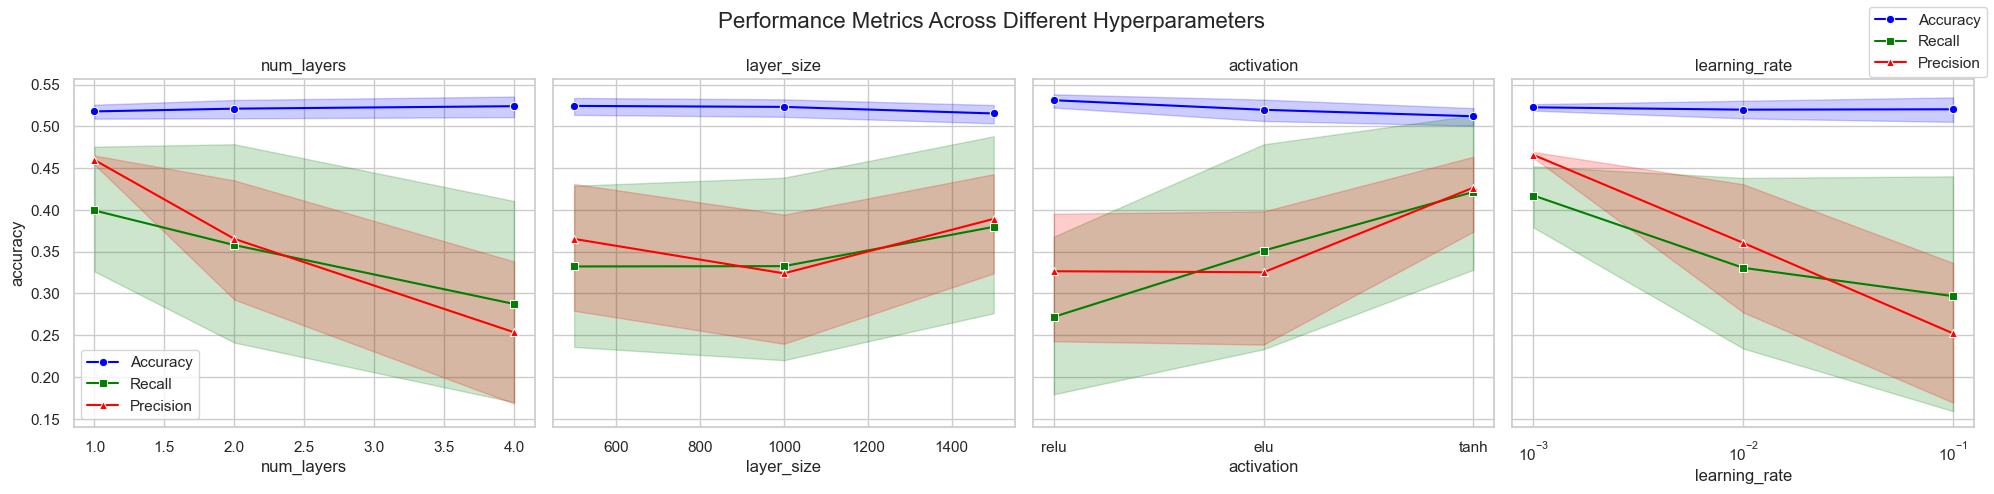

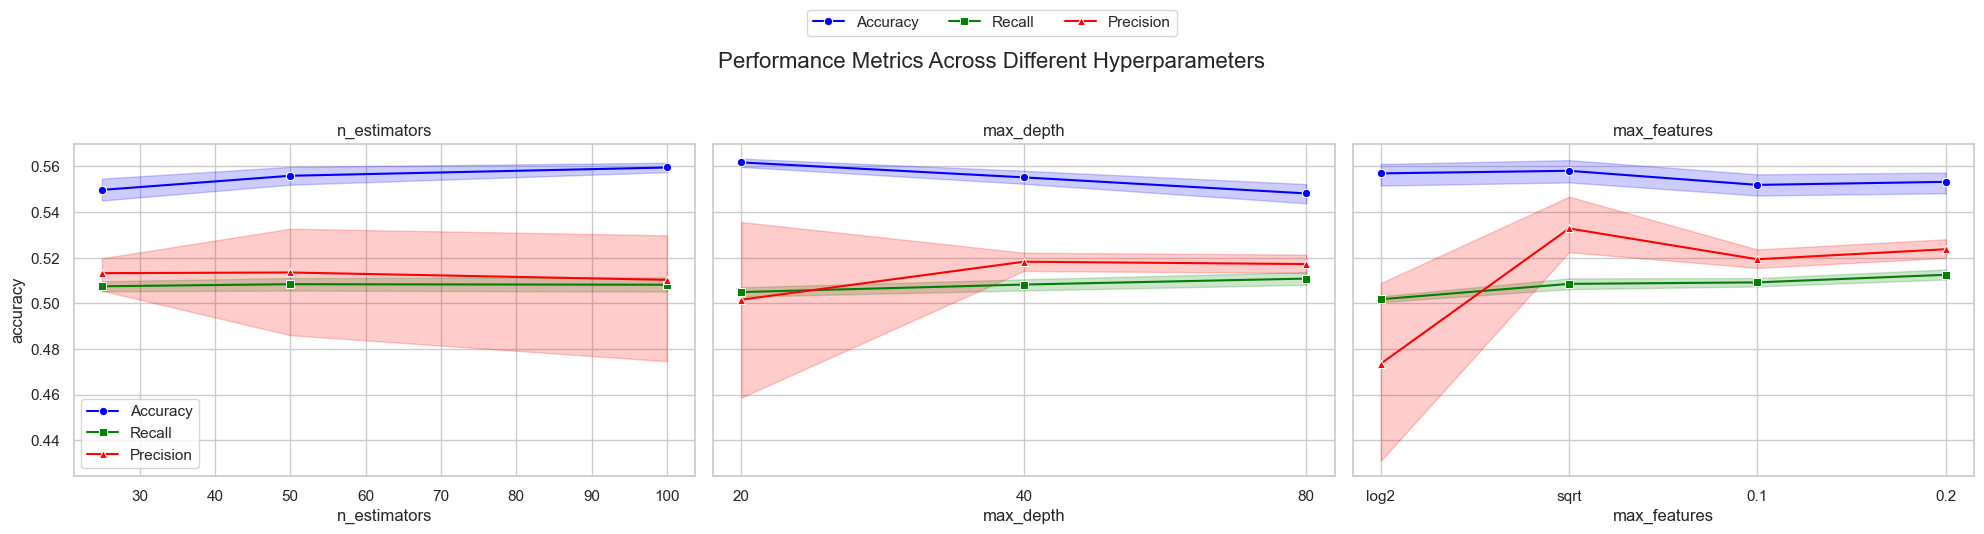

In [18]:
graph_hpp_testing('sparse_hyperparameter_data.csv')
graph_random_forest_hpp_testing('random_forest_hyperparameter_data.csv')

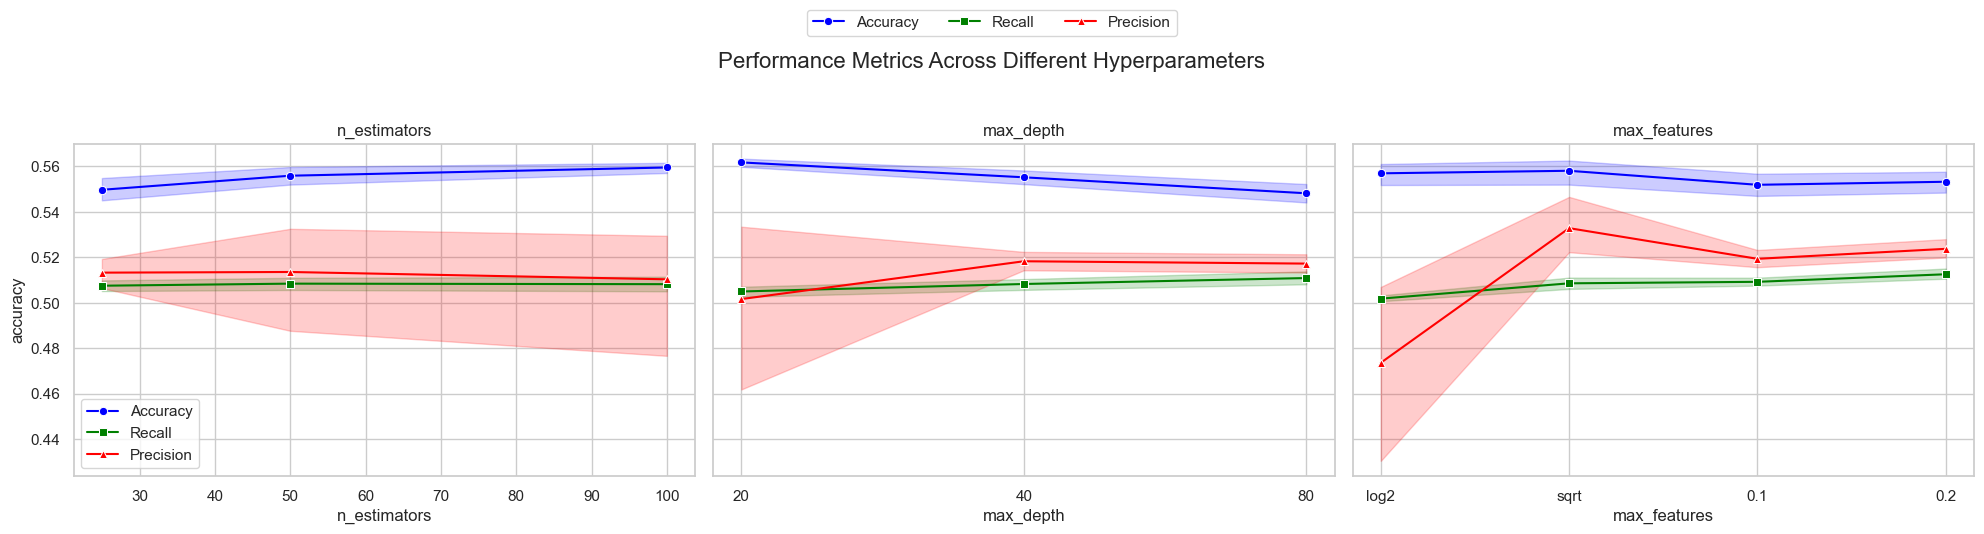